# Importing Train and Test Data

In [11]:
import zipfile

zip_file_path = './imagerecog.zip'
extracted_folder_path = '/content'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

In [4]:
import os
import torch
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torch.utils.data import random_split
from PIL import Image

# Transforming the Data into a Tensor

In [12]:
train_folder_path = '/content/train'

######### some hyperparameters ##########
seed = 12168423785814237708
img_size = 224
batch_size = 32
learning_rate = 0.0001
momentum = 0.9
lambd = 0.001
epochs = 12
#########################################
torch.manual_seed(seed)

data_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# custom dataset loader from folders
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_folder = ImageFolder(root=root_dir, transform=self.transform)

    def find_folder_containing_image(self, root_folder, target_image):
      for folder, _, files in os.walk(root_folder):
          if target_image in files:
              return os.path.basename(folder)
      return None  # image not found in any subfolder (shouldn't ever happen)

    def load_image(self, folder, image_name):
        image_path = os.path.join(self.root_dir, folder, image_name)
        return Image.open(image_path).convert("RGB")

    def __len__(self):
        return len(self.image_folder)

    def __getitem__(self, idx):
        img_id = str(idx) + ".jpg"
        folder_name = self.find_folder_containing_image(self.root_dir, img_id)

        if folder_name is not None:
            img = self.load_image(folder_name, img_id)
            if self.transform:
                img = self.transform(img)
        #print(img_id, folder_name)
        return img, int(folder_name)

# train_data contains both features and labels in one structure
train_data = CustomDataset(root_dir=train_folder_path, transform=data_transform)

augmentation_transform = transforms.Compose([
    transforms.RandomResizedCrop(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

augmented_train_data = CustomDataset(root_dir=train_folder_path, transform=augmentation_transform)
train_data = torch.utils.data.ConcatDataset([train_data, augmented_train_data])
print("after data augmentation: ", len(train_data))

# train/val split
Xy_train, Xy_val = train_test_split(train_data, test_size=0.1)

# create dataloaders
train_loader = DataLoader(Xy_train, batch_size, shuffle=True)
val_loader = DataLoader(Xy_val, batch_size, shuffle=False)

for images, labels in train_loader:
  print(images.shape)
  print(labels)
  break

print(len(Xy_train), len(Xy_val))

after data augmentation:  2158
torch.Size([32, 3, 224, 224])
tensor([33, 59, 43, 93, 95, 87, 36, 76, 43, 92, 59,  7, 41, 19, 28, 63, 38, 83,
        62, 55, 11, 94, 75, 18, 66, 43, 17,  4, 97,  7, 33, 65])
1942 216


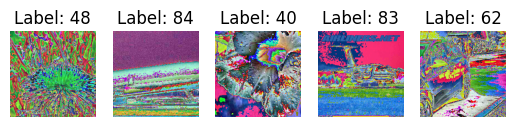

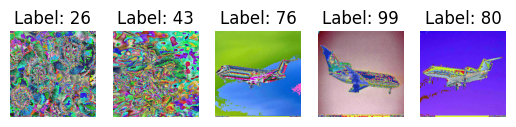

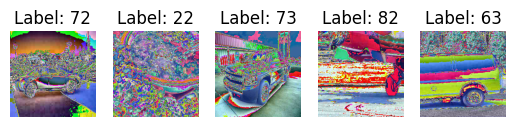

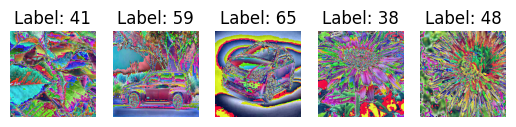

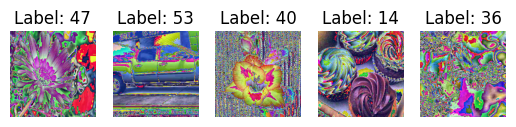

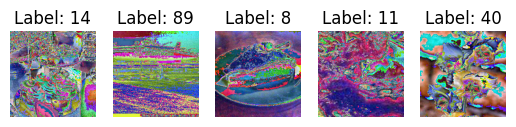

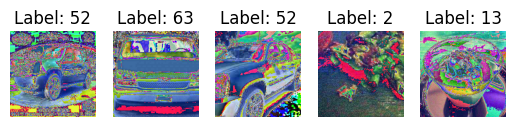

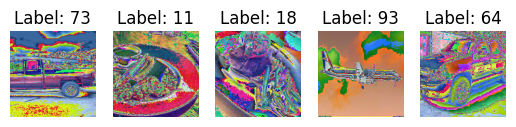

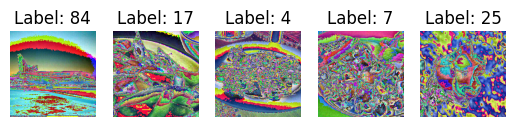

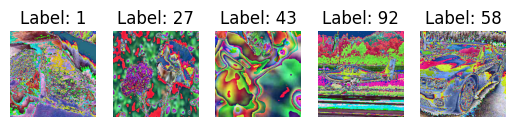

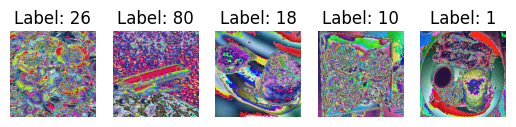

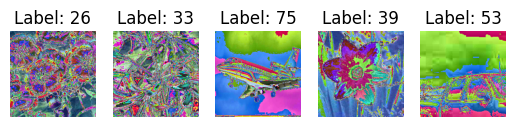

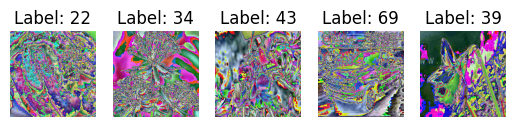

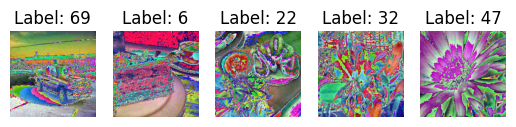

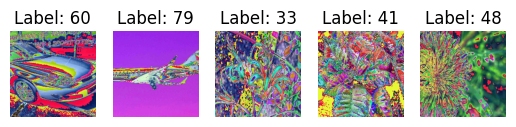

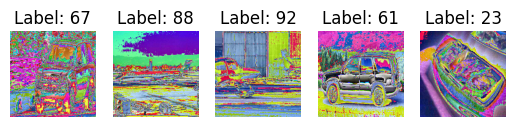

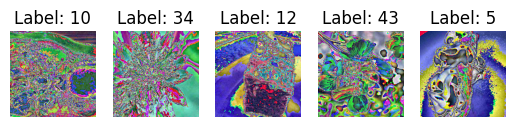

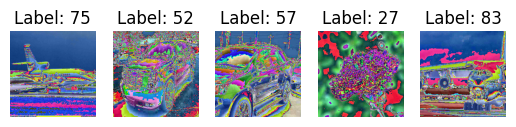

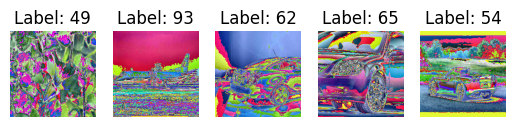

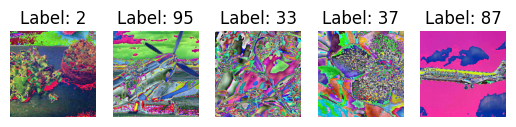

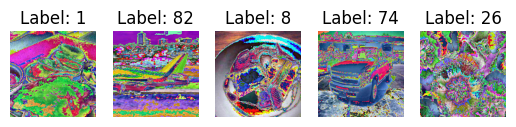

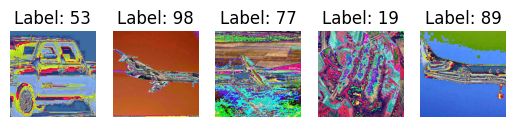

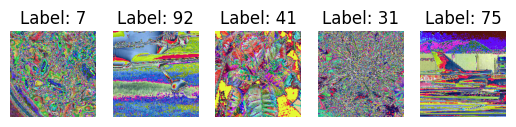

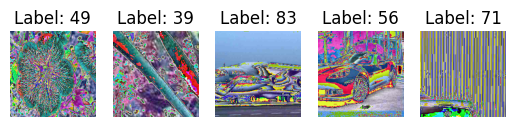

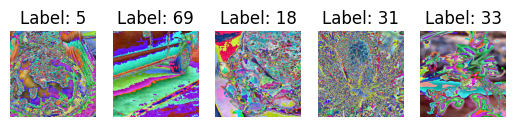

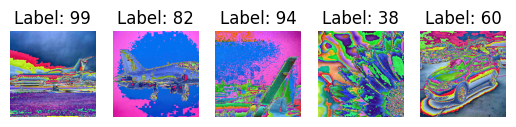

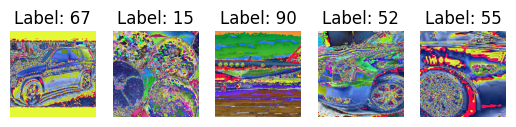

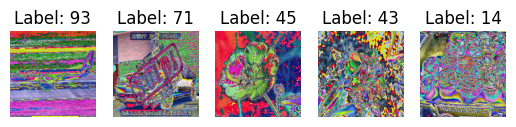

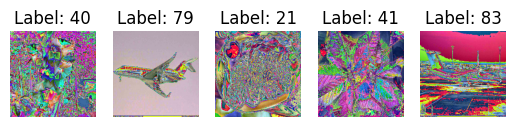

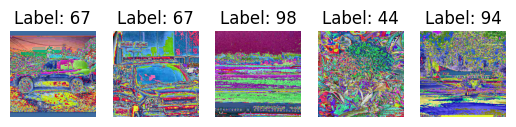

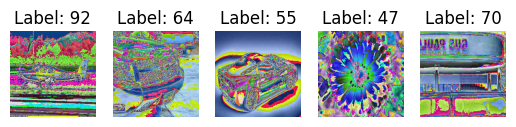

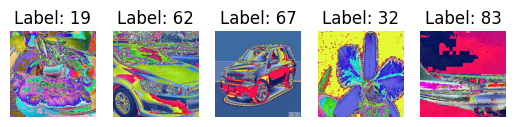

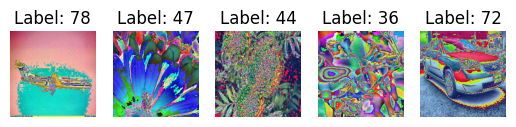

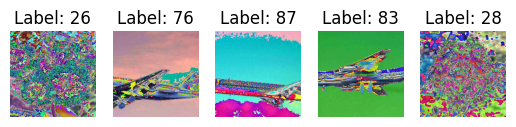

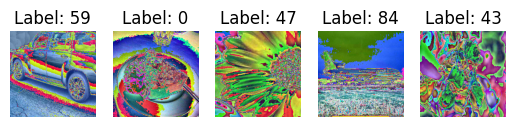

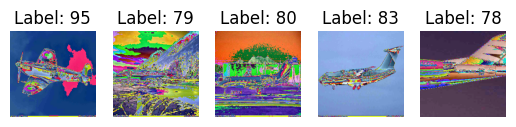

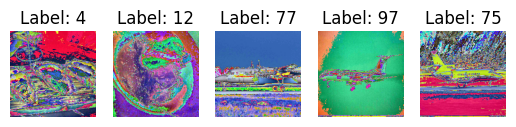

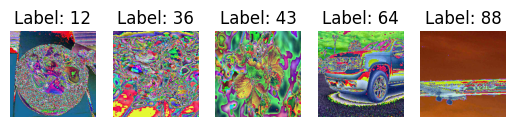

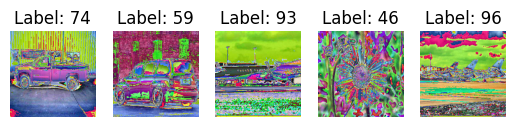

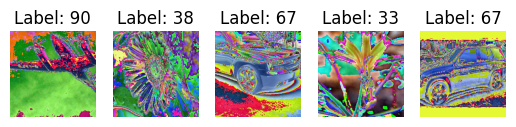

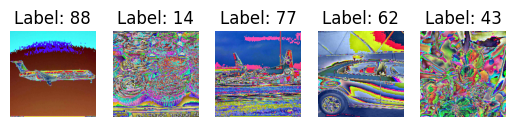

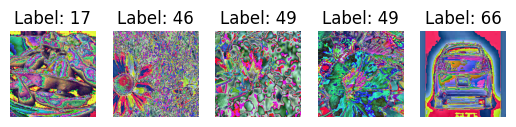

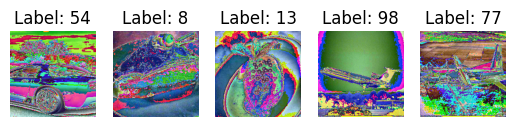

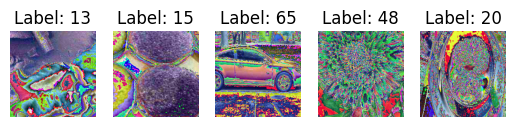

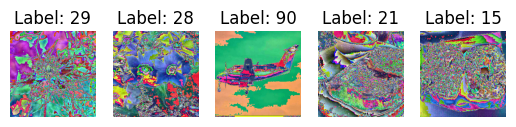

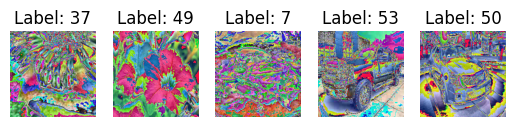

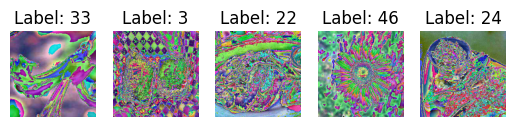

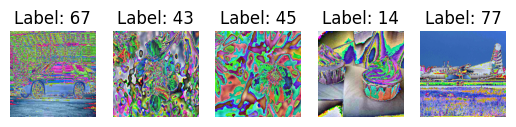

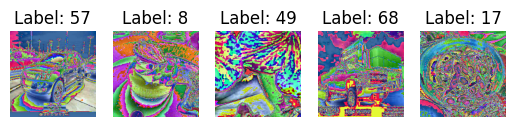

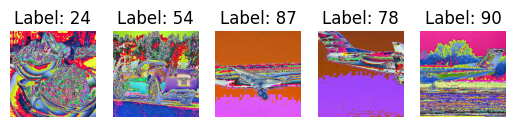

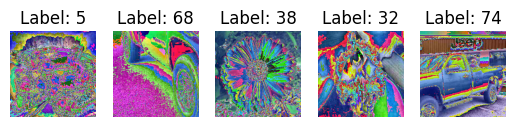

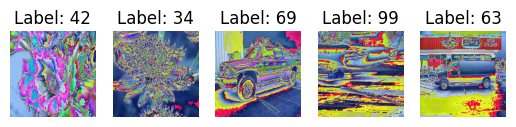

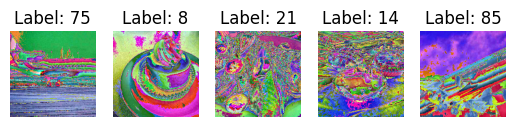

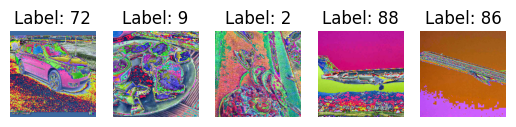

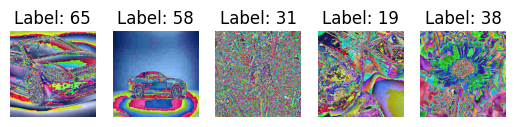

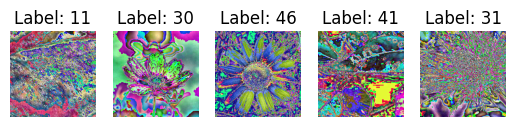

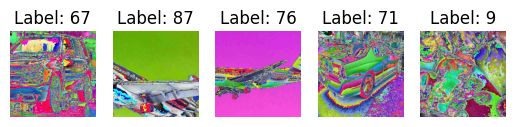

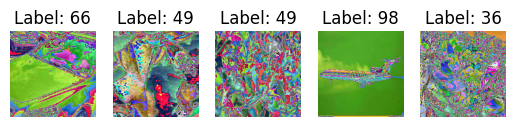

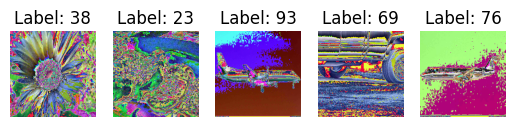

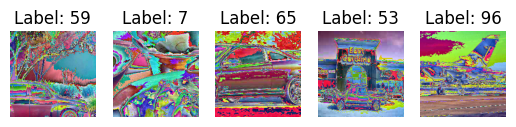

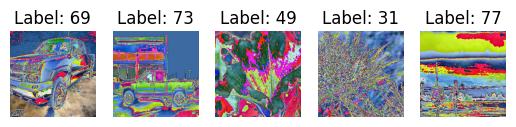

In [13]:
import matplotlib.pyplot as plt
'''c = 0
for inputs, labels in train_loader:
    transform_to_pil = transforms.ToPILImage()
    image_pil = transform_to_pil(inputs[0])
    print(labels[0])
    plt.imshow(image_pil)
    c += 1
    if c == 10: break'''

transform_to_pil = transforms.ToPILImage()

for batch_idx, (inputs, labels) in enumerate(train_loader):
    # Plot the first few images in the batch
    num_images_to_plot = 5
    for i in range(min(num_images_to_plot, inputs.size(0))):
        image_pil = transform_to_pil(inputs[i])
        plt.subplot(1, num_images_to_plot, i + 1)
        plt.imshow(image_pil)
        plt.title(f"Label: {labels[i].item()}")
        plt.axis("off")

    plt.show()

In [16]:
import torch
import torch.nn as nn
import torchvision.models as models
from PIL import Image
import pandas as pd
import random

# load ResNet-50 backbone
resnet50 = models.resnet50(pretrained=True)
# resnet50.load_state_dict(torch.load('/content/Final_Weights.pth'))

# freeze every pre-trained layer
for param in resnet50.parameters():
    param.requires_grad = True

# retrain, or unfreeze some layers
num_classes = 100
resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)

for param in resnet50.layer4.parameters():
    param.requires_grad = True

for param in resnet50.layer3.parameters():
    param.requires_grad = False

# define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet50.parameters(), lr=learning_rate, weight_decay=lambd)

# training loop
train_loss_hist = []
train_acc_hist = []
val_loss_hist = []
val_acc_hist = []
for epoch in range(epochs):
    correct = 0
    total = 0
    iter = 0
    for inputs, labels in train_loader:
        iter += 1
        optimizer.zero_grad()

        outputs = resnet50(inputs)

        loss = criterion(outputs, labels)
        train_loss_hist.append(loss.item())
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels.squeeze()).sum().item()
        print(f"batch: {iter} | epoch: {epoch}/{epochs} | train loss: {loss.item()}")

        loss.backward()
        optimizer.step()
    train_acc_hist.append(correct/total)

    # Validation
    resnet50.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = resnet50(inputs)

            val_loss = criterion(outputs, labels).item()
            val_loss_hist.append(val_loss)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels.squeeze()).sum().item()
    val_acc_hist.append(correct/total)
    print(f'epoch {epoch+1}/{epochs} | val loss: {val_loss/len(val_loader):.4f} | val accuracy: {(correct/total)*100:.4f}%')

batch: 1 | epoch: 0/12 | train loss: 4.661441326141357
batch: 2 | epoch: 0/12 | train loss: 4.579324722290039
batch: 3 | epoch: 0/12 | train loss: 4.718752861022949
batch: 4 | epoch: 0/12 | train loss: 4.585242748260498
batch: 5 | epoch: 0/12 | train loss: 4.555870532989502
batch: 6 | epoch: 0/12 | train loss: 4.565423488616943
batch: 7 | epoch: 0/12 | train loss: 4.482616901397705
batch: 8 | epoch: 0/12 | train loss: 4.263441562652588
batch: 9 | epoch: 0/12 | train loss: 4.400045394897461
batch: 10 | epoch: 0/12 | train loss: 4.296780109405518
batch: 11 | epoch: 0/12 | train loss: 4.323330879211426
batch: 12 | epoch: 0/12 | train loss: 4.420641899108887
batch: 13 | epoch: 0/12 | train loss: 4.057462692260742
batch: 14 | epoch: 0/12 | train loss: 4.101036071777344
batch: 15 | epoch: 0/12 | train loss: 3.9720191955566406
batch: 16 | epoch: 0/12 | train loss: 3.712031841278076
batch: 17 | epoch: 0/12 | train loss: 3.9473893642425537
batch: 18 | epoch: 0/12 | train loss: 4.2493896484375
b

In [ ]:
# save model weights to a file
weights_path = '/content/resnet50_weights.pth'
torch.save(resnet50.state_dict(), weights_path)

In [ ]:
# test set loader
from torch.utils.data import Dataset
import re

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [file for file in os.listdir(root_dir) if file.endswith('.jpg')]
        self.image_ids = self.image_files

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # get numeric part of id only
        numeric_part = re.search(r'\d+', self.image_ids[idx]).group()
        numeric_value = int(numeric_part)
        return image, numeric_value

test_data_path = '/content/test'

test_data = CustomDataset(root_dir=test_data_path, transform=data_transform)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4)

for images, ids in test_loader:
  print(images.shape)
  print(ids)
  break

In [ ]:
# test set inference
ids = []
pred = []

resnet50.eval()
with torch.no_grad():
    for images, ids2 in test_loader:
        outputs = resnet50(images)
        _, predicted = torch.max(outputs, 1)
        ids.append(list(ids2))
        pred.append(predicted)
    pred = torch.cat(pred, dim=0)

ids = [item for sublist in ids for item in sublist]

csv_data = []
for i in range(len(ids)):
  csv_data.append([ids[i].item(), pred[i].item()])

csv_data = sorted(csv_data, key=lambda x: x[0])      # sort by ascending ids

csv_data.insert(0, ['ID', 'Label'])
for i in range(1, len(csv_data)):
  id = csv_data[i][0]
  csv_data[i][0] = str(id) + '.jpg'

print(csv_data)

In [ ]:
# generate csv file from inference data
import csv

csv_file_path = "/content/output.csv"

with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(csv_data)

In [ ]:
# plot stats
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs[0, 0].plot(train_loss_hist)
axs[0, 0].set_title('Train Loss')

axs[0, 1].plot(train_acc_hist)
axs[0, 1].set_title('Train Accuracy')

axs[1, 0].plot(val_loss_hist)
axs[1, 0].set_title('Validation Loss')

axs[1, 1].plot(val_acc_hist)
axs[1, 1].set_title('Validation Accuracy')

plt.tight_layout()
plt.show()